# Collect and filter AlphaFold output

In [1]:
# %load_ext lab_black
# Python standard library
from glob import glob, iglob
import os
import socket
import sys

# 3rd party library imports
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers
running on node: dig31


In [2]:
scores_dict = {}

for json_file in iglob('04_alphafold_one_state/output/job*/output/*.json'):
    json_series = pd.read_json(json_file, orient='records', typ='series')
    pdb_file = json_file.replace('prediction_results.json', 'unrelaxed.pdb')
    scores_dict[pdb_file] = json_series

scores_df = pd.DataFrame.from_dict(scores_dict, orient='index')
scores_df

,mean_plddt,recycles,tol,model,type,seed,rmsd_to_input,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_interaction,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_pae_intra_chain,mean_pae,pTMscore,elapsed_time
04_alphafold_one_state/output/job1099/output/03_close_loops_78cb37619c1041b7933193481aa02515_model_4_ptm_seed_0_unrelaxed.pdb,87.023918,3,1.308762,4,monomer_ptm,0,11.369291,28.566286,28.547520,28.556904,4.880112,6.951226,5.915669,17.257559,0.486916,242.261087
04_alphafold_one_state/output/job1099/output/03_close_loops_785ea38175804882b5ed73b0b3f72df0_model_4_ptm_seed_0_unrelaxed.pdb,41.079857,3,4.151548,4,monomer_ptm,0,21.511078,26.260981,26.163673,26.212326,16.818254,17.915512,17.366882,22.523796,0.358758,64.653105
04_alphafold_one_state/output/job1099/output/03_close_loops_7905428ac8a5446fa61e4de1653a16f4_model_4_ptm_seed_0_unrelaxed.pdb,80.780571,3,0.143393,4,monomer_ptm,0,16.297840,14.330722,13.684651,14.007687,5.409476,7.058187,6.233831,10.165806,0.676465,188.103795
04_alphafold_one_state/output/job1099/output/03_close_loops_790914f02aac4a5cbf0410763fc7d4ef_model_4_ptm_seed_0_unrelaxed.pdb,79.625015,3,3.864013,4,monomer_ptm,0,8.391392,20.320978,20.326654,20.323816,7.207901,6.018441,6.613172,13.502185,0.531382,71.386953
04_alphafold_one_state/output/job1099/output/03_close_loops_78ea46e42e124ddfb298aa29fa40a97e_model_4_ptm_seed_0_unrelaxed.pdb,80.817490,3,0.575100,4,monomer_ptm,0,15.841295,19.759239,18.863125,19.311182,9.005863,5.541681,7.273772,13.702390,0.577593,65.650626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04_alphafold_one_state/output/job1493/output/03_close_loops_b82656876ee6473a9d4df36778f3823c_model_5_ptm_seed_0_unrelaxed.pdb,76.853851,3,1.740341,5,monomer_ptm,0,3.683950,10.814352,10.606471,10.710411,6.824565,7.719255,7.271910,9.001184,0.690285,222.652008
04_alphafold_one_state/output/job1493/output/03_close_loops_b7e3a5a0514344a6b408913bf92e2f6a_model_5_ptm_seed_0_unrelaxed.pdb,86.049744,3,0.384931,5,monomer_ptm,0,16.587746,9.273797,7.983353,8.628575,3.698303,5.965513,4.831908,6.765745,0.810312,231.257540
04_alphafold_one_state/output/job1493/output/03_close_loops_b8185e2c7921400aa7c80481cb1c90a8_model_5_ptm_seed_0_unrelaxed.pdb,68.041115,3,0.976959,5,monomer_ptm,0,8.946616,16.485445,14.990390,15.737917,6.857453,9.589757,8.223605,15.915647,0.524579,84.261535
04_alphafold_one_state/output/job1493/output/03_close_loops_b7f90c33dd0c4d3e864c683d62103bfb_model_5_ptm_seed_0_unrelaxed.pdb,68.324692,3,1.014323,5,monomer_ptm,0,11.150941,26.079918,26.301430,26.190674,6.700246,5.992772,6.346509,20.853352,0.386766,54.407870


6it [00:00,  7.51it/s]


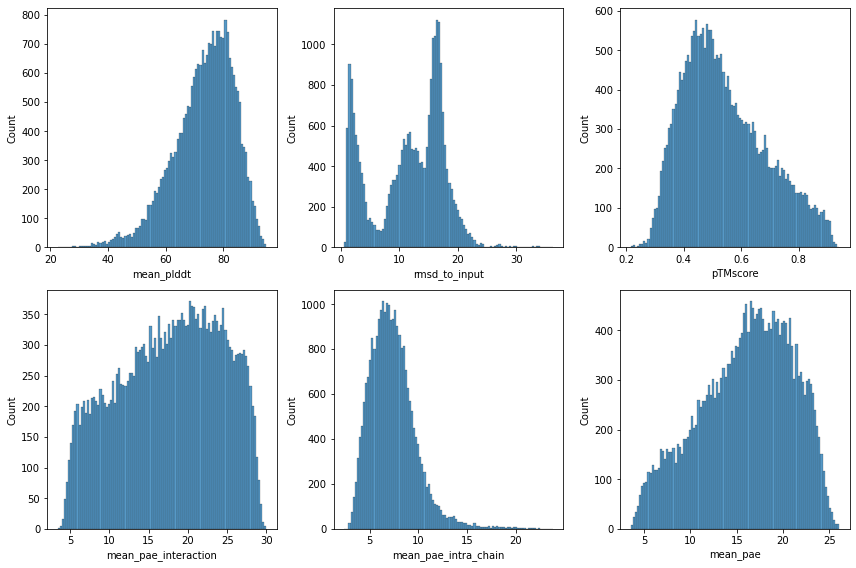

In [3]:
import sys
sys.path.insert(0, '/home/broerman/projects/crispy_shifty/')
from crispy_shifty.plotting.utils import histplot_df

cols = [
        "mean_plddt",
        "rmsd_to_input",
        "pTMscore",
        "mean_pae_interaction",
        "mean_pae_intra_chain",
        "mean_pae",
    ]

# make sure all the columns to plot are numeric
scores_df[cols] = scores_df[cols].astype(float)
histplot_df(scores_df, cols=cols, bins=100)

# pairplot these as well

In [4]:
def filter_df(df, cutoffs):
    filtered_df = df

    for score_term, cutoff, greaterthan in cutoffs:
        if greaterthan:
            filtered_df = filtered_df[filtered_df[score_term] > cutoff]
        else:
            filtered_df = filtered_df[filtered_df[score_term] < cutoff]

    print(len(filtered_df))
    
    return filtered_df

def filter_df_delta(df, parent_df, delta_cutoffs):
    filtered_df = df

    for score_term, parent_term, cutoff, greaterthan in delta_cutoffs:
        filtered_series = filtered_df[score_term]
        parent_scores = parent_df.loc[filtered_df['parent'], parent_term]
        parent_scores.index = filtered_series.index
        if greaterthan:
            filtered_df = filtered_df[filtered_series - parent_scores > -cutoff]
        else:
            filtered_df = filtered_df[filtered_series - parent_scores < cutoff]
    
    print(len(filtered_df))
    
    return filtered_df

In [5]:
# Filter designs

cutoffs = [('mean_plddt', 85, 1),
           ('rmsd_to_input', 3, 0),
           ('pTMscore', 0.8, 1)
]

filtered_df = filter_df(scores_df, cutoffs)
filtered_df

1095


,mean_plddt,recycles,tol,model,type,seed,rmsd_to_input,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_interaction,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_pae_intra_chain,mean_pae,pTMscore,elapsed_time
04_alphafold_one_state/output/job1077/output/03_close_loops_658831d49dbe4ae3b2043af0bb5b507b_model_4_ptm_seed_0_unrelaxed.pdb,89.844872,3,0.392372,4,monomer_ptm,0,1.108072,5.323590,5.688773,5.506181,3.313630,4.441612,3.877621,6.795893,0.861108,235.842485
04_alphafold_one_state/output/job1194/output/03_close_loops_c69771753a694019b10543a69e53d425_model_4_ptm_seed_0_unrelaxed.pdb,92.811142,3,0.193028,4,monomer_ptm,0,1.205951,5.019908,4.783030,4.901469,3.699190,3.613771,3.656480,4.326745,0.918589,51.772228
04_alphafold_one_state/output/job1194/output/03_close_loops_c69a4d5494f643d38a6ae09be17c277f_model_4_ptm_seed_0_unrelaxed.pdb,90.214539,3,0.153886,4,monomer_ptm,0,1.488523,6.272862,6.311093,6.291978,4.383603,3.839523,4.111563,5.264213,0.865567,165.341374
04_alphafold_one_state/output/job1000/output/03_close_loops_2706aa1bfeb3478d968cf41503a69c51_model_4_ptm_seed_0_unrelaxed.pdb,87.212807,3,1.761540,4,monomer_ptm,0,1.530908,7.235410,6.190323,6.712867,5.233863,3.840409,4.537136,5.672986,0.844948,81.886350
04_alphafold_one_state/output/job407/output/03_close_loops_4831498d629142ad84f0249e2b9c0637_model_2_ptm_seed_0_unrelaxed.pdb,88.538803,3,7.408896,2,monomer_ptm,0,1.099821,6.648568,6.482279,6.565423,4.349007,4.209496,4.279252,5.466416,0.850617,62.720723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04_alphafold_one_state/output/job1400/output/03_close_loops_6b3f1bd513d447188e568dda13a07aef_model_5_ptm_seed_0_unrelaxed.pdb,88.494102,3,0.245805,5,monomer_ptm,0,1.865985,5.737846,6.201699,5.969772,3.351262,4.475757,3.913509,5.956464,0.844750,164.887061
04_alphafold_one_state/output/job193/output/03_close_loops_9bc2ba4c493b42afa62673688193bde8_model_1_ptm_seed_0_unrelaxed.pdb,89.907249,3,1.480032,1,monomer_ptm,0,1.191563,6.168674,5.713274,5.940974,4.423534,3.725437,4.074485,5.062375,0.890473,123.144619
04_alphafold_one_state/output/job193/output/03_close_loops_9c4be376cbbb4dd3a92e6b5cecdb3315_model_1_ptm_seed_0_unrelaxed.pdb,89.536926,3,0.394151,1,monomer_ptm,0,1.315886,4.765512,4.892465,4.828989,3.774654,3.583641,3.679147,6.814555,0.865409,102.384619
04_alphafold_one_state/output/job1030/output/03_close_loops_4009197a657a41848a79d236876f97d3_model_4_ptm_seed_0_unrelaxed.pdb,88.728668,3,7.795997,4,monomer_ptm,0,1.488509,6.004909,6.443728,6.224319,3.585422,4.312149,3.948785,5.632129,0.864548,81.969254


In [6]:
print(filtered_df['rmsd_to_input'].mean())

1.663020712218872


In [7]:
# Get the scores of everything pre-alphafold

def read_scorefile(scores):
    import pandas as pd

    scores = pd.read_json(scores, orient="records", typ="frame", lines=True)
    scores = scores.T
    mat = scores.values
    n = mat.shape[0]
    dicts = list(mat[range(n), range(n)])
    index = scores.index
    tabulated_scores = pd.DataFrame(dicts, index=index)
    return tabulated_scores

looped_scores_df = read_scorefile('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/scores.json')
looped_scores_df

,abego_str_A,abego_str_B,bb_clash,bb_clash_A,bb_clash_B,closure_type_A,closure_type_B,cms_ac_bn,cms_dhr,cms_dhr_ac,...,wnm_1,wnm_2,wnm_3,wnm_4,wnm_A,wnm_B,wnm_hlx,yhh_planarity,remodel_after_loop_B,remodel_before_loop_B
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0000/03_close_loops_7a29eaf4497c4d0b8e6bf9849d490710.pdb.bz2,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAGB...,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAAAGB...,3941.285888671875,104.71414184570312,44.70890426635742,loop_remodel,loop_match,-1.0,563.556396484375,558.30126953125,...,0.3609829246997833,0.31814438104629517,0.390592098236084,0.3623688817024231,0.9452593324444125,0.6644087555430732,0.13865715265274048,0.0,NaN,NaN
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0000/03_close_loops_751d888198554aa6a3a1f233411c9f12.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,114.33641815185547,56.87188720703125,56.87188720703125,loop_remodel,loop_remodel,-1.0,443.7602844238281,492.1199645996094,...,0.3382881283760071,0.34088292717933655,0.36499300599098206,0.3650842010974884,0.9878179683704182,0.7401864406856012,0.12189187854528427,0.0,3,1
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0000/03_close_loops_63b5af9d88284226b46175a72f9c22e1.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,XAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAGBAAA...,104.14654541015625,52.073272705078125,52.073272705078125,loop_remodel,loop_remodel,-1.0,481.5782775878906,710.6294555664062,...,0.2017073929309845,0.2055833488702774,0.194741889834404,0.1623128205537796,0.7819809655914953,0.744621290767556,0.1379878669977188,0.0,3,1
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0000/03_close_loops_b354c617c3e649dbbe1dcf1c41b13009.pdb.bz2,XAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABBBAAAAAAA...,XAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABBBAAAAAAA...,2720.452880859375,41.73583221435547,41.73583221435547,loop_remodel,loop_remodel,-1.0,413.3935546875,648.1015625,...,0.30959227681159973,0.308468759059906,0.2922387719154358,0.29739323258399963,0.855336758143723,0.6750440484361641,0.1376577615737915,0.0,3,3
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0000/03_close_loops_99080a1854744a57a5e930eb0506b539.pdb.bz2,XAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABBBAAAAAAA...,XAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAABBBAAAAAAA...,770.9017944335938,41.73583221435547,41.73583221435547,loop_remodel,loop_remodel,-1.0,426.1754150390625,623.4779052734375,...,0.3173397481441498,0.27061134576797485,0.3077307343482971,0.3143083453178406,0.5831864549675589,0.9640519331830376,0.09920351207256317,0.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0005/03_close_loops_9b6688697b1a45faad6a189aa2430ea0.pdb.bz2,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,XAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAA...,650.278564453125,63.48990249633789,63.49613571166992,loop_match,loop_match,-1.0,657.4190063476562,932.1930541992188,...,0.2842772603034973,0.27961069345474243,0.25029444694519043,0.3099098801612854,0.9502259592476284,0.45107840599119337,0.13451702892780304,0.820741428680763,NaN,NaN
/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/03_close_loops/decoys/0005/03_close_loops_ddc429e7ebe8424db77546ff40edc455.pdb.bz2,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAAGBAA...,222.9122314453125,50.16154861450195,53.20732116699219,loop_match,loop_match,-1.0,637.9689331054688,686.9913940429688,...,0.2928754389286041,0.23006823658943176,0.2433444857597351,0.25700628757476807,0.33005253309841404,0.6594513879277119,0.09973601996898651,0.0,NaN,NaN
/home/broerman/projects/crispy_shifty/projects/crispy

In [23]:
# Copy selected designs and write PyRosettaCluster-like metadata

import bz2
import collections
import json
import os
import uuid
from crispy_shifty.utils.io import _get_output_dir

for index, row in filtered_df.iterrows():

    scores = row.to_dict()
    scores.pop('seed')
    scores.pop('elapsed_time')

    looped_uuid = index.split('_')[-7]
    selected_looped_df = looped_scores_df[[looped_uuid in s for s in looped_scores_df.index]]
    looped_pdb_path = selected_looped_df.index[0]
    looped_scores = selected_looped_df.to_dict(orient='records')[0]
    
    scores.update(looped_scores)
    # print(scores)
    # print(looped_pdb_path)

    output_dir = _get_output_dir('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/')
    decoy_name = "_".join(['04_alphafold_one_state', uuid.uuid4().hex])
    output_file = os.path.join(output_dir, decoy_name + '.pdb.bz2')

    pdbfile_data = json.dumps(
        {
            "instance": {"compressed": True, "decoy_dir_name": "decoys", "environment": "", "output_path": "/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state", "simulation_name": "04_alphafold_one_state", "simulation_records_in_scorefile": False, "tasks": {"pdb_path": looped_pdb_path, 'af_pdb_path': index}},
            "metadata": {"decoy_name": decoy_name, "output_file": output_file},
            "scores": collections.OrderedDict(sorted(scores.items())),
        }
    )

    with open(index, 'r') as f:
        pdbstring = f.read()

    # Write full .pdb record
    pdbstring_data = pdbstring + os.linesep + "REMARK PyRosettaCluster: " + pdbfile_data
    with open(output_file, "wb") as f:
        f.write(bz2.compress(str.encode(pdbstring_data)))
        
    scorefile_data = json.dumps(
        {
            output_file: collections.OrderedDict(
                sorted(scores.items())
            ),
        }
    )
    # Write data to new scorefile
    with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/scores.json', "a") as f:
        f.write(scorefile_data + '\n')

In [6]:
with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected.list', 'w') as f:
    for file in glob('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/*/*.pdb.bz2'):
        f.write(file + '\n')

In [10]:
# Make a list of the design models of the selected designs

uuids = []

with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design.list', 'w') as f:
    for index, row in filtered_df.iterrows():
        looped_uuid = index.split('_')[-7]
        if looped_uuid not in uuids:
            selected_looped_df = looped_scores_df[[looped_uuid in s for s in looped_scores_df.index]]
            looped_pdb_path = selected_looped_df.index[0]
            f.write(looped_pdb_path + '\n')
            uuids.append(looped_uuid)

In [19]:
# Make lists of the af2 and design models of designs with parents DHR39, DHR62, and DHR82

uuids = []

with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_design_sample.list', 'w') as fd:
    for index, row in filtered_df.iterrows():
        scores = row.to_dict()

        looped_uuid = index.split('_')[-7]
        selected_looped_df = looped_scores_df[[looped_uuid in s for s in looped_scores_df.index]]
        looped_pdb_path = selected_looped_df.index[0]
        looped_scores = selected_looped_df.to_dict(orient='records')[0]

        scores.update(looped_scores)

        if scores['parent'] in ['DHR39', 'DHR62', 'DHR82']:
            if looped_uuid not in uuids:
                fd.write(looped_pdb_path + '\n')
                uuids.append(looped_uuid)

paths = []
import pyrosetta.distributed.cluster as cluster

with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_af2_sample.list', 'w') as fa:
    with open('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/selected_af2_sample_firstmodel.list', 'w') as fa1:
        for file in glob('/home/broerman/projects/crispy_shifty/projects/crispy_shifty_dimers/04_alphafold_one_state/decoys/*/*.pdb.bz2'):
            scores = cluster.get_scores_dict(file)
#             print(scores)
            looped_design_path = scores['instance']['tasks']['pdb_path']

            if scores['scores']['parent'] in ['DHR39', 'DHR62', 'DHR82']:
                fa.write(file + '\n')
                if looped_design_path not in paths:
                    fa1.write(file + '\n')
                    paths.append(looped_design_path)